### Import libraries

In [2]:
#!pip install -q -U transformers
#!pip install -q -U accelerate
#!pip install -q -U bitsandbytes
!pip install pandas matplotlib
!pip install keras-tuner


#import os
import pandas as pd
import tensorflow as tf
### scegliere la migliore
#import nltk
#from nltk.corpus import stopwords
#nltk.download('stopwords')
#stop = set(stopwords.words('english'))

import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

#import gensim
#from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
###
import string
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
from nltk.stem import PorterStemmer

# Creare un oggetto PorterStemmer
stemmer = PorterStemmer()

# Esempio di frase
sentence = "The running foxes are better than the jumping dogs."

# Tokenizza la frase in parole
words = sentence.split()

# Applicare lo stemming a ciascuna parola
stemmed_words = [stemmer.stem(word) for word in words]

# Ricostruire la frase con le parole stemmate
stemmed_sentence = ' '.join(stemmed_words)

# Stampa il risultato
print(f"Original: {sentence}")
print(f"Stemmed: {stemmed_sentence}")

nlp = spacy.load("en_core_web_sm")

# Usa nlp.pipe per lemmatizzare

def lemmatization_with_spacy(nlp,text):
  doc = nlp(text)
  lemmatized_result = [token.lemma_ for token in doc]
  return ' '.join(lemmatized_result)
print(f"Lemmatized: {lemmatization_with_spacy(nlp,sentence)}")
print(f"Stemmed and lemmatized: {lemmatization_with_spacy(nlp,stemmed_sentence)}")



Original: The running foxes are better than the jumping dogs.
Stemmed: the run fox are better than the jump dogs.
Lemmatized: the run fox be well than the jump dog .
Stemmed and lemmatized: the run fox be well than the jump dog .


### Read dataset

In [84]:
path_to_dataset = ""
file_name = "daigt_v3.csv"
#Per comodità, per capire se stiamo eseguendo su Google Colab o su Kaggle
if os.path.exists('/content/'):
        path_to_dataset = f"/content/{file_name}"

    # Verifica se è presente la cartella "input" caratteristica di Kaggle
if os.path.exists('/kaggle/input/'):
        path_to_dataset = f"/kaggle/input/daigt-v2-train-dataset/{file_name}"

df = pd.read_csv(path_to_dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47503 entries, 0 to 47502
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0.1   47503 non-null  int64  
 1   text           47501 non-null  object 
 2   label          47502 non-null  float64
 3   prompt_name    47502 non-null  object 
 4   source         47502 non-null  object 
 5   RDizzl3_seven  43602 non-null  object 
 6   id             43602 non-null  float64
 7   Unnamed: 0     3306 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 2.9+ MB


### Data preparation



In [85]:
df = df.drop('source',axis = 1)
df = df.drop('RDizzl3_seven',axis = 1)
df = df.drop('prompt_name',axis = 1)
df.head()

,Unnamed: 0.1,text,label,id,Unnamed: 0
0,0,Phones\n\nModern humans today are always on th...,0.0,0.0,NaN
1,1,This essay will explain if drivers should or s...,0.0,1.0,NaN
2,2,Driving while the use of cellular devices\n\nT...,0.0,2.0,NaN
3,3,Phones & Driving\n\nDrivers should not be able...,0.0,3.0,NaN
4,4,Cell Phone Operation While Driving\n\nThe abil...,0.0,4.0,NaN


In [86]:
# roba da fare in extended dataset
df = df.drop("Unnamed: 0.1",axis=1)
df = df.drop("Unnamed: 0",axis=1)
df = df.drop("id",axis=1)
df.columns
df = df.dropna()


#### Function to remove stop words

In [88]:
#NLTK
def remove_stop_words_nltk(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop]
    return ' '.join(filtered_words)

#SPACY
def remove_stop_words_spacy(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

#GENSIM
def remove_stop_words_gensim(text):
  new_text = remove_stopwords(text)
  return new_text

In [89]:
df['text'][0]

"Phones\n\nModern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it.\n\nWhen people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation.\n\nDriving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to reme

In [90]:
for index,row in df.iterrows():
  new_string = remove_stop_words_spacy(row['text'])
  df.at[index,'text'] = new_string.lower()

df['text'][0]

"phones modern humans today phone. phone 5 hours day stop .all text forward group chats social media. driving. bad consequences stuff happens comes phone. certain areas united states ban phones class rooms it. people phones, know certain apps .apps like facebook twitter instagram snapchat. like friend moves away want contact contact posting videos text messages. people different ways communicate phone. phones changed generation. driving way around. people phones it. cause problems. that's there's thing that's called texting driving. that's important thing remember. people think it's stupid. matter obey that's way save. news accident suicide. involve looking they're going tweet sent. injury death. mysterious number says i'm going kill know live don't know person's contact ,it makes puzzled start freak out. end badly. phones fine use it's best way come help. problem can't find help ,always phone you. phones day long you're safe come use trouble. sure like phone you're middle driving. new

#### Function to remove punctuation

In [91]:
print(string.punctuation)
def remove_punctuation_with_string(text):
    new_text = ""
    for word in text:
      for i in range(len(word)):
        if word[i] not in string.punctuation:
          new_text+=word[i]
    return new_text


!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [92]:
for index,row in df.iterrows():
  new_string = remove_punctuation_with_string(row['text'])
  df.at[index,'text'] = new_string


df['text'][0]

'phones modern humans today phone phone 5 hours day stop all text forward group chats social media driving bad consequences stuff happens comes phone certain areas united states ban phones class rooms it people phones know certain apps apps like facebook twitter instagram snapchat like friend moves away want contact contact posting videos text messages people different ways communicate phone phones changed generation driving way around people phones it cause problems thats theres thing thats called texting driving thats important thing remember people think its stupid matter obey thats way save news accident suicide involve looking theyre going tweet sent injury death mysterious number says im going kill know live dont know persons contact it makes puzzled start freak out end badly phones fine use its best way come help problem cant find help always phone you phones day long youre safe come use trouble sure like phone youre middle driving news updated people stupid involves phones safe

#### Function to lemmatize

In [93]:
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')  # Assicurati di scaricare il corpus di WordNet
lemmatizer = WordNetLemmatizer()
def lemmatization_with_nltk(lemmatizer,text):
  words = text.split()
# Lemmatizza ciascuna parola
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
# Ricostruisci la stringa lemmatizzata
  lemmatized_sentence = ' '.join(lemmatized_words)
  return lemmatized_sentence
word = "The students eagerly immersed themselves in their studies, exploring new concepts and collaborating to deepen their understanding of various subjects"
print(f"Original: {word}")
print(f"Lemmatized: {lemmatization_with_nltk(lemmatizer,word)}")

Original: The students eagerly immersed themselves in their studies, exploring new concepts and collaborating to deepen their understanding of various subjects
Lemmatized: The student eagerly immersed themselves in their studies, exploring new concept and collaborating to deepen their understanding of various subject


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [94]:
import spacy

nlp = spacy.load("en_core_web_sm")

# Usa nlp.pipe per lemmatizzare

def lemmatization_with_spacy(nlp,text):
  doc = nlp(text)
  lemmatized_result = [token.lemma_ for token in doc]
  return ' '.join(lemmatized_result)

print(f"Original: {df['text'][1]}")
print(f"Lemmatized: {lemmatization_with_spacy(nlp,df['text'][1])}")

Original: essay explain drivers able use electronic devices operating vehicle phone driving cause bad wrecks putting people risk people able use cell phones operating vehicle bad wrecks putting others lives danger cause death all wrecks caused looking phone driving importantly eyes directly road wheel car note outrageously car payment looking phone moreover reason accident happened person operating car sue lots money pay it therefore dont pay person charges consequences served thats bars reason able use cell phones operating automobile putting peoples lives danger thus looking cell phone hurt uncommunicative act committed unconsciousness injuries hospital main key texting driving wheel car mainly cause tragic terrifying horrific things thats death thats important thing electronic devices operating vehicle intension keeping eyes staying focus road easily turn road hit victim possibly humankind away flesh stupidity remembered stay focus road destination safely so cant cause accidents peo

In [95]:
for index,row in df.iterrows():
  new_string = lemmatization_with_spacy(nlp,row['text'])
  print(index)
  df.at[index,'text'] = new_string


df['text'][0]
df2 = df.copy()

Output streaming troncato alle ultime 5000 righe.
42501
42502
42503
42504
42505
42506
42507
42508
42509
42510
42511
42512
42513
42514
42515
42516
42517
42518
42519
42520
42521
42522
42523
42524
42525
42526
42527
42528
42529
42530
42531
42532
42533
42534
42535
42536
42537
42538
42539
42540
42541
42542
42543
42544
42545
42546
42547
42548
42549
42550
42551
42552
42553
42554
42555
42556
42557
42558
42559
42560
42561
42562
42563
42564
42565
42566
42567
42568
42569
42570
42571
42572
42573
42574
42575
42576
42577
42578
42579
42580
42581
42582
42583
42584
42585
42586
42587
42588
42589
42590
42591
42592
42593
42594
42595
42596
42597
42598
42599
42600
42601
42602
42603
42604
42605
42606
42607
42608
42609
42610
42611
42612
42613
42614
42615
42616
42617
42618
42619
42620
42621
42622
42623
42624
42625
42626
42627
42628
42629
42630
42631
42632
42633
42634
42635
42636
42637
42638
42639
42640
42641
42642
42643
42644
42645
42646
42647
42648
42649
42650
42651
42652
42653
42654
42655
42656
42657
42658
42

The operation above takes up to 30 mins. We decide to take it as proof of our operations but we can start from this point reading already cleaned DAIGT-v3 dataset.

In [98]:
df.to_csv("/content/daigt_v3_without_sw_punct_and_lemmatized.csv",index = False)



**Import the libraries and start from here**

In [3]:
WITHOUT_STOP_WORDS_PUNCTUATION_AND_LEMMATIZED_PATH = "/content/daigt_v3_without_sw_punct_and_lemmatized.csv"
WITHOUT_STOP_WORDS_AND_LEMMATIZED_PATH = "Not exists."
df = pd.read_csv(WITHOUT_STOP_WORDS_PUNCTUATION_AND_LEMMATIZED_PATH)

In [4]:
df.columns

Index(['text', 'label'], dtype='object')

#### Split dataset

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Create the text encoder

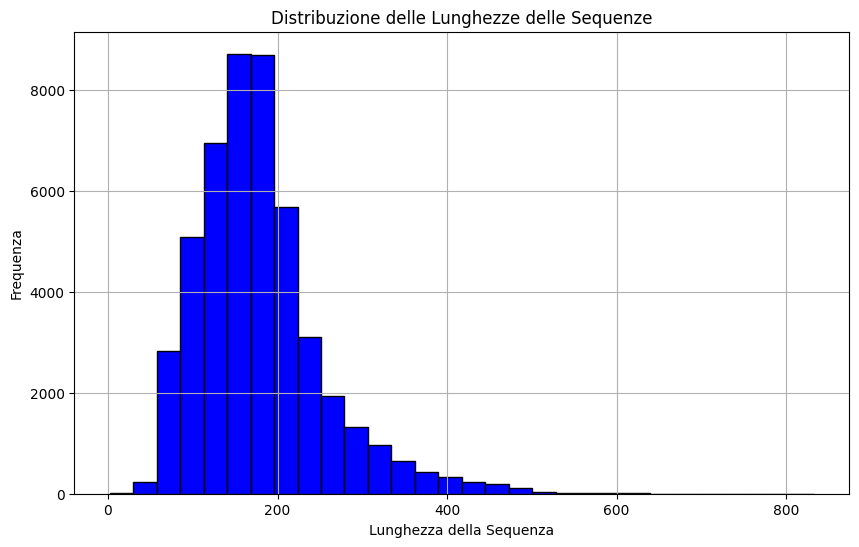

In [108]:
df['sequence_length'] = df['text'].apply(lambda x: len(x.split()))

# Crea un istogramma delle lunghezze delle sequenze
plt.figure(figsize=(10, 6))
plt.hist(df['sequence_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribuzione delle Lunghezze delle Sequenze')
plt.xlabel('Lunghezza della Sequenza')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

df = df.drop('sequence_length',axis=1)

# proviamo sia con 500 che con 800 come max-length




In [116]:
df_filtrato = df[df['text'].apply(lambda x: len(x.split())) >= 400]
len(df_filtrato)

812

In [8]:
train_data = pd.DataFrame({'text': X_train, 'label': y_train})
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label']))

In [113]:

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    output_sequence_length=500,
    standardize=None,
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [114]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'student', 'car', 'people', 'school', 'not', 'help',
       'like', 'time', 'work', 'do', 'learn', 'think', 'way', 'good',
       'phone', 'class', 'need', 'vote'], dtype='<U15')

In [9]:
from keras_tuner.tuners import RandomSearch
def build_model(hp):

    VOCAB_SIZE = hp.Int('vocab_size_hp', min_value=1000, max_value=5000, step=500)
    encoder = tf.keras.layers.TextVectorization(
        output_sequence_length=hp.Int('output_sequence_length_hp', min_value=500, max_value=800, step=50),
        standardize=None,
        max_tokens=VOCAB_SIZE)
    encoder.adapt(train_dataset.map(lambda text, label: text))

    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(
            input_dim=len(encoder.get_vocabulary()),
            output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=256, step=32),
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=hp.Int('lstm_1_units', min_value=32, max_value=128, step=32),
            return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
            units=hp.Int('lstm_2_units', min_value=32, max_value=128, step=32))),
        tf.keras.layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'swish'])),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.7, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
from keras.metrics import Accuracy, SparseCategoricalCrossentropy
from sklearn.metrics import make_scorer



tuner = RandomSearch(
    build_model,
    objective='val_accuracy',#'val_accuracy',
    max_trials=5,  # Scegli il numero desiderato di prove
    directory='/content/hyperparameter_tuning/',
    project_name='text_classification_tuning'
)

tuner.search_space_summary()  # Stampa uno sguardo agli spazi di ricerca

tuner.search(X_train, y_train, epochs=20,batch_size=64, validation_data=(X_val, y_val))


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

print(f"Best Hyperparameters: {best_hps.values}")


In [15]:
print(best_hps.values)

{'vocab_size_hp': 2500, 'output_sequence_length_hp': 500, 'embedding_output_dim': 256, 'lstm_1_units': 64, 'lstm_2_units': 96, 'dense_units': 128, 'dense_activation': 'swish', 'dropout_rate': 0.30000000000000004, 'optimizer': 'sgd'}


### Create model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), #,  return_sequences=True # LSTM layer da provare
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'), # funzioni di attivazione, nodi o aggiungere layer
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_data=(X_val, y_val)) #modificare epochs e batch_size(tra 16 e 128)

Epoch 1/4
561/561 [==============================] - 489s 846ms/step - loss: 0.1222 - accuracy: 0.9506 - val_loss: 0.0487 - val_accuracy: 0.9851
Epoch 2/4
561/561 [==============================] - 474s 844ms/step - loss: 0.0614 - accuracy: 0.9823 - val_loss: 0.0466 - val_accuracy: 0.9851
Epoch 3/4
561/561 [==============================] - 462s 824ms/step - loss: 0.0426 - accuracy: 0.9872 - val_loss: 0.0421 - val_accuracy: 0.9869
Epoch 4/4
561/561 [==============================] - 480s 855ms/step - loss: 0.0297 - accuracy: 0.9913 - val_loss: 0.0401 - val_accuracy: 0.9866


### Evaluation

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

141/141 [==============================] - 18s 129ms/step - loss: 0.0523 - accuracy: 0.9844
Test Loss: 0.05233044549822807
Test Accuracy: 0.9843993782997131


In [ ]:
y_pred = model.predict(X_test.values)
y_pred = y_pred.astype(int)
y_test = y_test.astype(int)

# Stampa il classification report e l'accuracy score
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print(report)
print("****")
print(accuracy)

141/141 [==============================] - 19s 133ms/step
              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2729
           1       1.00      0.01      0.02      1758

    accuracy                           0.61      4487
   macro avg       0.81      0.50      0.39      4487
weighted avg       0.76      0.61      0.47      4487

****
0.6115444617784711


In [ ]:
ai_text = ('''Millions of people around the globe face the harsh reality of hunger every day. Despite progress, food insecurity remains a pressing issue, highlighting the urgent need for sustainable solutions to ensure access to nutritious meals for everyone.''')
predictions = model.predict(np.array([ai_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[0.99196714]]


In [ ]:
human_text = ('''Keith recently came back from a trip to Chicago, Illinois. This midwestern metropolis is found along the shore of Lake Michigan. During his visit, Keith spent a lot of time exploring the city to visit important landmarks and monuments.

Keith loves baseball, and he made sure to take a visit to Wrigley Field. Not only did he take a tour of this spectacular stadium, but he also got to watch a Chicago Cubs game. In the stadium, Keith and the other fans cheered for the Cubs. Keith was happy that the Cubs won with a score of 5-4.

Chicago has many historic places to visit. Keith found the Chicago Water Tower impressive as it is one of the few remaining landmarks to have survived the Great Chicago Fire of 1871. Keith also took a walk through Jackson Park, a great outdoor space that hosted the World’s Fair of 1892. The park is great for a leisurely stroll, and it still features some of the original architecture and replicas of monuments that were featured in the World’s Fair.

During the last part of his visit, Keith managed to climb the stairs inside of the Willis Tower, a 110-story skyscraper. Despite the challenge of climbing the many flights of stairs, Keith felt that reaching the top was worth the effort. From the rooftop, Keith received a gorgeous view of the city’s skyline with Lake Michigan in the background.''')
predictions = model.predict(np.array([human_text]))
print(predictions)

1/1 [==============================] - 0s 66ms/step
[[0.00258359]]


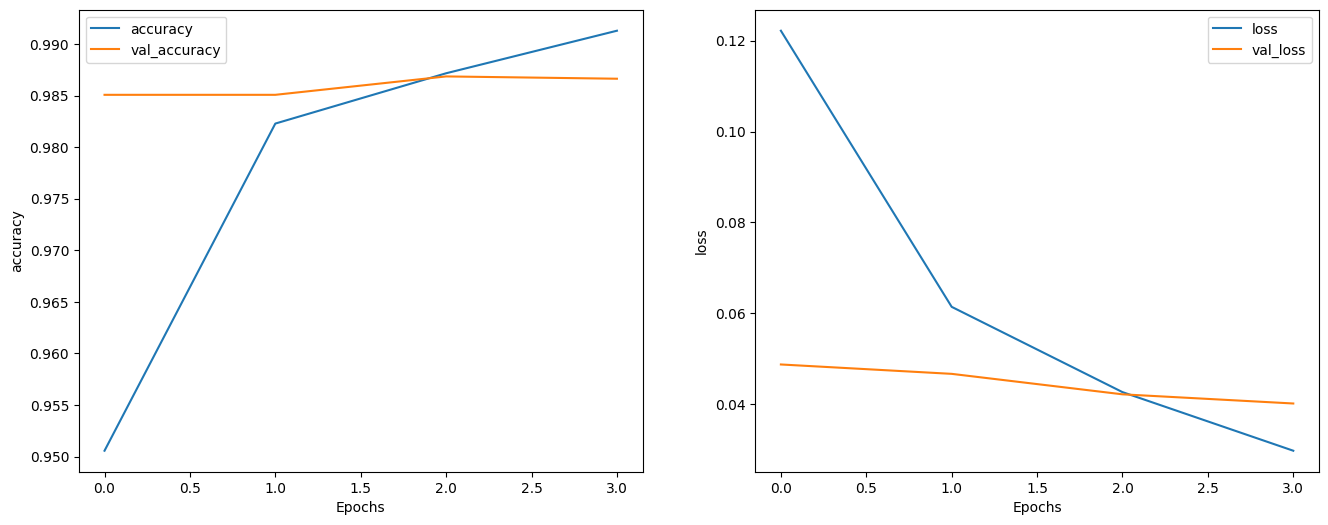

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')